In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Подключаем библиотеки

In [38]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
from matplotlib import pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14})

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [39]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Загружаем данные и делаем первоначальные преобразования

In [40]:
#train_dataset_path = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
train_dataset_path = 'C:/Users/Ivanovs/Documents/Projects/python/real-estate-price-prediction-moscow/train.csv'
df = pd.read_csv(train_dataset_path)

#test_dataset_path = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
test_dataset_path = 'C:/Users/Ivanovs/Documents/Projects/python/real-estate-price-prediction-moscow/test.csv'
test_df = pd.read_csv(test_dataset_path)

In [41]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)
df.rename(columns = {'Helthcare_2': "Healthcare_2"}, inplace = True)

#### Смотрим на выбросы и NaN значения

In [42]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Class для обработки и подготовки исходных данных

In [44]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.features = ['Square', 'LifeSquare','KitchenSquare','HouseFloor'];
        self.features_zero = ['HouseFloor'];
        self.nans = ['LifeSquare', 'Healthcare_1'];


        #self.kitchen_square_quantile = None
        
    def fit(self,X):
        """Сохранение статистик"""  
        
        # Расчет показателей
        self.q_zero = 0;
        self.q_mins = X[self.features].quantile(0.01);
        self.q_maxs = X[self.features].quantile(0.99);
    
    def transform(self,X):
        """Трансформация данных"""       
        
        #Цикл по признакам
        for feature in self.features:   

            median = X[feature].median()

            for q_min in self.q_mins.index:
                if feature == q_min:

                    title = '{}{}'.format(feature, '_outlier')
                    X[title]=0
                    X[title].loc[X[feature]<self.q_mins[q_min]]=1
                    X[feature].loc[X[feature]<self.q_mins[q_min]]=median

            for q_max in self.q_maxs.index:
                if feature == q_max:

                    title = '{}{}'.format(feature, '_outlier')
                    X[title]=0
                    X[title].loc[X[feature]>self.q_maxs[q_max]]=1
                    X[feature].loc[X[feature]>self.q_maxs[q_max]]=median

        #Цикл по NaN значениям  
        for na in self.nans:

            median = X[na].median()

            title = '{}{}'.format(na, '_nan')
            X[title]=0
            X.loc[X[na].isna(), title]=1
            X[na] = X[na].fillna(median)

        #Цикл по нулевым значениям    
        for feature_zero in self.features_zero:

            title = '{}{}'.format(feature_zero, '_outlier')
            X[title]=0
            X[title].loc[X[feature_zero]==0]=1
            X[feature_zero].loc[X[feature_zero]==0]=self.q_zero

        #Особые выбросы

        #Этаж не должен быть больше кол-ва этаже в доме. Заменяем на максимальный этаж в доме
        X['Floor_outlier'] = 0
        X['Floor_outlier'].loc[X['Floor']>X['HouseFloor']] = 1

        X['Floor'].loc[X['Floor']>X['HouseFloor']]=X['HouseFloor'].loc[X['Floor']>X['HouseFloor']]

        #Год не должен превышать 2020, в выборке присутствуют аномальные значения
        X['HouseYear_outlier'] = 0
        X['HouseYear_outlier'].loc[X['HouseYear']>2020] = 1

        X['HouseYear'].loc[X['HouseYear']>2020] = X['HouseYear'].median()

        #Применяем медиану на LifeSquare, которые больше Square
        #X.loc[X['LifeSquare']<X['Square']] = 0
        #df.loc[floor_outliers, 'HouseFloor']\.apply(lambda x: random.randint(1, x))
        
        return X

#### Class генерации новых фич

In [45]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

#### Целевая переменная

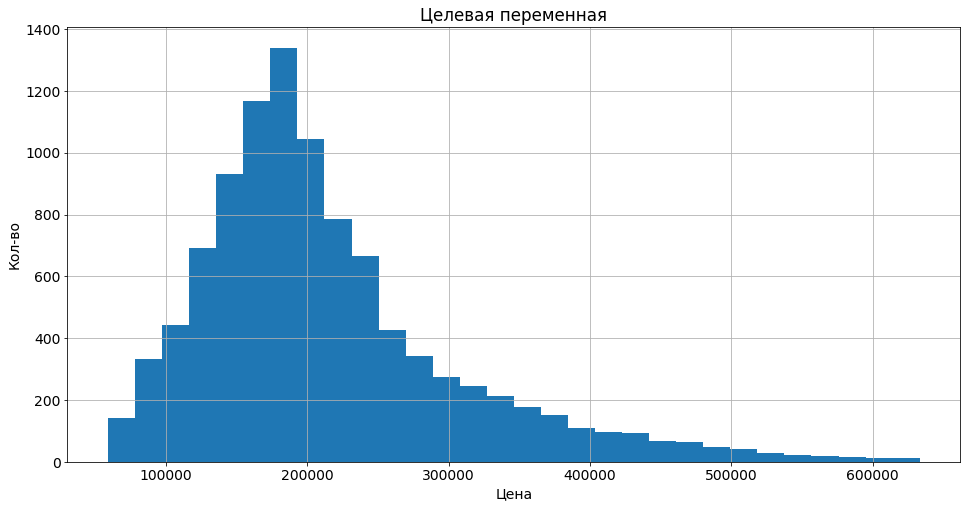

In [46]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('Кол-во')
plt.xlabel('Цена')

plt.title('Целевая переменная')
plt.show()

In [47]:
target = 'Price'

#### Разбиение на test и train

In [48]:
#train_dataset_path = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
train_dataset_path = 'C:/Users/Ivanovs/Documents/Projects/python/real-estate-price-prediction-moscow/train.csv'
df = pd.read_csv(train_dataset_path)

#test_dataset_path = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
test_dataset_path = 'C:/Users/Ivanovs/Documents/Projects/python/real-estate-price-prediction-moscow/test.csv'
test_df = pd.read_csv(test_dataset_path)

In [49]:
X = df.drop(columns = target)
y = df[target]

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 27), (3000, 27), (5000, 27))

In [52]:
features_gen = FeatureGenetator()
features_gen.fit(X_train,y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 34), (3000, 34), (5000, 34))

In [53]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_nan,Floor_outlier,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,14858,31,1.0,38.234365,20.008121,8.0,3.0,3.0,1977.0,0.000000,...,1,1,0,40,0,0,0.0,2,188273.510830,179525.641685
1,8231,11,1.0,31.309445,24.479166,5.0,1.0,5.0,1969.0,0.038693,...,0,0,0,88,0,0,0.0,2,156717.722314,179525.641685
2,3799,123,2.0,47.234446,19.363580,6.0,2.0,12.0,1980.0,0.000000,...,0,0,0,18,0,0,0.0,2,321106.306078,179525.641685
3,11635,61,3.0,63.841680,38.098612,8.0,9.0,12.0,1983.0,0.300323,...,1,0,0,81,0,0,2.0,3,260456.004692,226532.510597
4,16592,27,1.0,36.054331,34.296082,1.0,15.0,17.0,2016.0,0.011654,...,1,0,0,594,0,1,3.0,5,118309.315585,177572.825837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,6137,22,3.0,79.650439,32.616950,1.0,19.0,20.0,1977.0,0.118537,...,0,0,0,60,0,0,4.0,2,216503.243877,174946.216488
6996,4451,1,3.0,79.953687,32.616950,1.0,12.0,17.0,1977.0,0.007122,...,1,0,0,477,0,1,3.0,2,244005.272380,184050.533213
6997,13236,11,1.0,39.698660,25.570715,7.0,5.0,9.0,1982.0,0.038693,...,0,0,0,88,0,0,1.0,3,156717.722314,214385.231309
6998,10404,6,1.0,43.613432,3.668460,1.0,3.0,17.0,2016.0,0.243205,...,0,0,0,362,0,1,0.0,5,130636.710519,172115.179629


In [54]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge']

target_name = 'Price'

In [55]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

#### Обучение модели

In [56]:
rf_model = RandomForestRegressor(random_state=42, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### Оценка модели

Train R2:	0.961
Test R2:	0.714


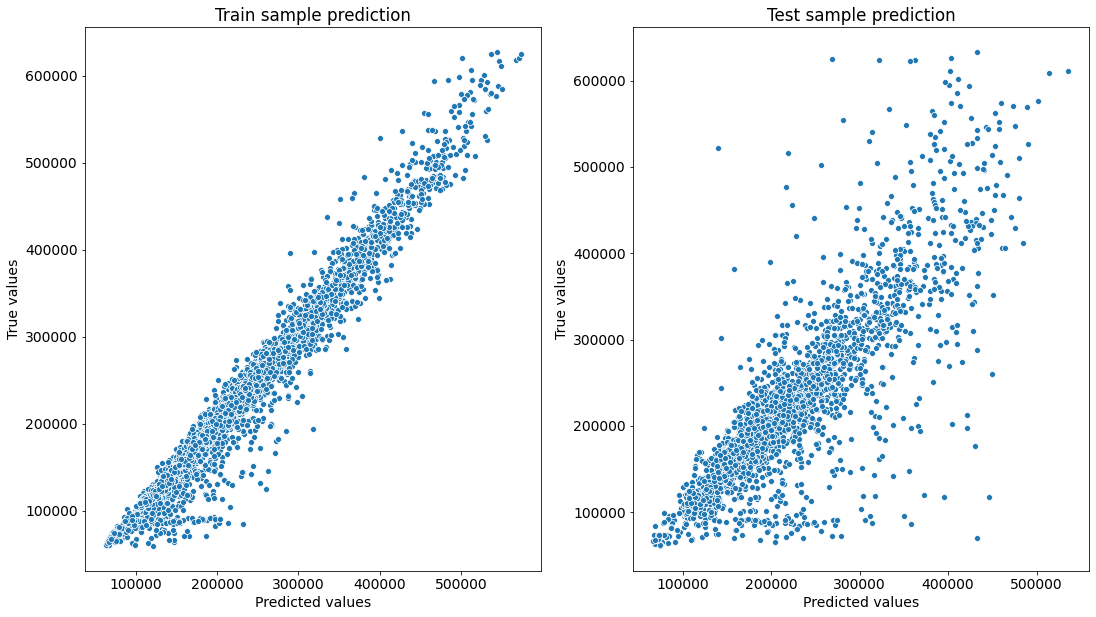

In [57]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [58]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.70670304, 0.7257687 , 0.67550702])

In [59]:
cv_score.mean()

0.7026595872887548

#### Важность признаков

In [60]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.325420
19,DistrictSize,0.211112
0,Rooms,0.133995
12,Social_3,0.054930
6,HouseYear,0.041980
2,LifeSquare,0.039493
7,Ecology_1,0.035831
11,Social_2,0.027937
5,HouseFloor,0.027403
10,Social_1,0.024663


#### Более сложные модели

In [61]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()
stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.919
Test R2:	0.707


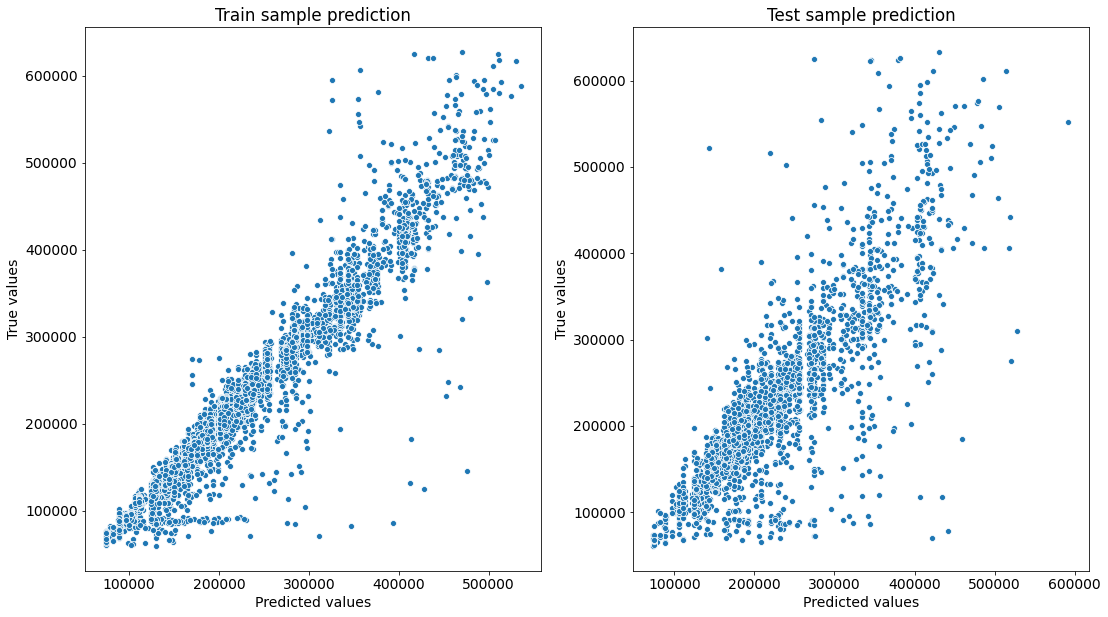

In [62]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Прогнозирование результатов

In [63]:
test_df.shape

(5000, 22)

In [64]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970.0,0.036122,1,1,...,0,1,1,1,0,0,0,73.0,0,0
1,1.0,42.493907,42.568133,10.0,7.0,17.0,2017.0,0.072158,1,1,...,1,0,0,0,0,0,0,173.0,0,1
2,2.0,59.463678,32.925087,9.0,19.0,19.0,1977.0,0.211401,1,1,...,0,0,1,1,0,0,1,594.0,0,1
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965.0,0.014073,1,1,...,0,0,0,1,0,0,0,390.0,0,1
4,1.0,53.837056,32.925087,1.0,8.0,17.0,1977.0,0.309479,1,1,...,4,0,6,1,0,0,1,79.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5.0,5.0,1962.0,0.069660,1,1,...,4,1,2,1,0,0,0,62.0,0,0
4996,3.0,93.698122,32.925087,10.0,12.0,12.0,2018.0,0.060753,1,1,...,2,0,7,1,0,0,0,25.0,0,0
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966.0,0.038693,1,1,...,1,2,5,1,0,0,0,71.0,0,0
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970.0,0.089040,1,1,...,5,0,11,1,0,0,0,36.0,0,0


In [65]:
#submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit = pd.read_csv('C:/Users/Ivanovs/Documents/Projects/python/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [66]:
predictions = rf_model.predict(test_df)
predictions

array([158236.26422103, 119103.0727282 , 141922.18401193, ...,
       146262.48088297, 193457.73618918, 261333.50852475])

In [67]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158236.264221
1,5925,119103.072728
2,960,141922.184012
3,3848,187863.401631
4,746,206651.613103


In [68]:
submit.to_csv('rf_submit.csv', index=False)